<a href="https://colab.research.google.com/github/parrpary/KCdetec_FarabiDataset/blob/main/ResNet50_channelVise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Source](https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset

# Device configuration
device = torch.device('cuda') # if torch.cuda.is_available() else 'cpu'


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# Hyper-parameters
Number_of_classes = 3
batch_size = 21
num_epochs = 30
learning_rate = 0.001

In [4]:
# Load Dataset - FARABI

data = np.load('/content/gdrive/MyDrive/AR/CNN/farabi/data_channelvise224.npy')
labels = np.load('/content/gdrive/MyDrive/AR/CNN/farabi/labels_channelvise224.npy')

Data (293, 224, 224, 12) <class 'numpy.ndarray'>
Label (293,) <class 'numpy.ndarray'>


Text(0.5, 1.0, 'concat3')

<Figure size 432x288 with 0 Axes>

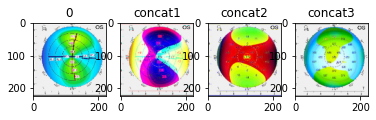

In [5]:
print("Data", data.shape, type(data))
print("Label", labels.shape, type(labels))

plt.figure()
f, axarr = plt.subplots(1,4)

axarr[0].imshow(data[0,:,:,0:3])
axarr[0].set_title(labels[0])

axarr[1].imshow(data[0,:,:,2:5])
axarr[1].set_title("concat1")
                     
axarr[2].imshow(data[0,:,:,4:7])
axarr[2].set_title("concat2")
                     
axarr[3].imshow(data[0,:,:,7:10])
axarr[3].set_title("concat3")

In [6]:
dataa = []
for i in range(data.shape[0]):
  img = data[i,:,:,:]
  img = img.transpose(2,0,1)
  dataa.append(img)

dataa = np.array(dataa, dtype=np.float64)

del data

print("Data", dataa.shape, type(dataa))
print("Label", labels.shape, type(labels))

Data (293, 12, 224, 224) <class 'numpy.ndarray'>
Label (293,) <class 'numpy.ndarray'>


In [7]:
dataa, labels = shuffle(dataa, labels)

train_input, test_input, train_target, test_target = train_test_split(dataa,
                                                                      labels,
                                                                      shuffle=True,
                                                                      test_size=0.255)

# test_input, test_target = data_input[-15:], data_target[-15:]
# train_input, train_target = data_input[:-15], data_target[:-15]
# valid_target_org = valid_target
# valid_target = to_categorical(valid_target)

test_target_org = test_target
train_target_org = train_target

train_target = to_categorical(train_target)
test_target = to_categorical(test_target)

In [8]:
print('Train set:', train_input.shape,  train_target.shape)
print('Test set:', test_input.shape,  test_target.shape)

Train set: (218, 12, 224, 224) (218, 3)
Test set: (75, 12, 224, 224) (75, 3)


In [9]:
## Images
# train_input = train_input.reshape((-1, 1, 28, 28))
# test_input = test_input.reshape((-1, 1, 28, 28))
train_input = torch.tensor(train_input)
test_input = torch.tensor(test_input)

## Labels
# train_target = train_target.reshape(train_target.shape[0], 1)
train_target = torch.tensor(train_target)

# test_target = test_target.reshape(test_target.shape[0], 1)
test_target = torch.tensor(test_target)

# print('Train set:', train_input.shape,  train_target.shape)
# print('Test set:', test_input.shape,  test_target.shape)

In [10]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


def imshow(img, title=''):
    """Plot the image batch.
    """
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()


# # Dataset w/o any tranformations
# train_dataset_normal = CustomTensorDataset(tensors=(X_train, y_train), transform=None)
# # train_loader = torch.utils.data.DataLoader(train_dataset_normal, batch_size=batch_size)

# # iterate
# for i, data in enumerate(train_loader):
#     x, y = data  
#     imshow(torchvision.utils.make_grid(x, 4), title='Normal')
#     break  # we need just one batch


# Let's add some transforms

# Dataset with flipping tranformations

def vflip(tensor):
    """Flips tensor vertically.
    """
    tensor = tensor.flip(1)
    return tensor


def hflip(tensor):
    """Flips tensor horizontally.
    """
    tensor = tensor.flip(2)
    return tensor

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(32),
    # transforms.ToTensor()
    ])

train_dataset = CustomTensorDataset(tensors=(train_input, train_target), transform=transform)
test_dataset = CustomTensorDataset(tensors=(test_input, test_target), transform=transform)
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)


In [11]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        x = x.float()
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=12, num_classes=Number_of_classes):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=12, num_classes=Number_of_classes):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=12, num_classes=Number_of_classes):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)
    
model = ResNet50(img_channel=12, num_classes=3).to(device)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [13]:
# Train the model
sample_loss = 100

total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        this_loss = loss.item()
        # Save the model checkpoint
        if this_loss < sample_loss:
          torch.save(model.state_dict(), 'resnet18_channelVise_Farabi.ckpt')
          print("Save: Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))
          sample_loss = this_loss

        if (i+1) % 7 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 5 == 0:
        curr_lr /= 2.3
        update_lr(optimizer, curr_lr)

Epoch [1/30], Step [7/11] Loss: 1.5434
Epoch [2/30], Step [7/11] Loss: 0.9783
Epoch [3/30], Step [7/11] Loss: 0.4697
Epoch [4/30], Step [7/11] Loss: 0.6142
Epoch [5/30], Step [7/11] Loss: 0.8157
Epoch [6/30], Step [7/11] Loss: 0.5041
Epoch [7/30], Step [7/11] Loss: 0.3280
Epoch [8/30], Step [7/11] Loss: 0.4840
Epoch [9/30], Step [7/11] Loss: 0.4255
Epoch [10/30], Step [7/11] Loss: 0.1766
Epoch [11/30], Step [7/11] Loss: 0.2946
Epoch [12/30], Step [7/11] Loss: 0.3968
Epoch [13/30], Step [7/11] Loss: 0.1071
Epoch [14/30], Step [7/11] Loss: 0.2614
Epoch [15/30], Step [7/11] Loss: 0.4646
Epoch [16/30], Step [7/11] Loss: 0.1320
Epoch [17/30], Step [7/11] Loss: 0.1659
Epoch [18/30], Step [7/11] Loss: 0.4476
Epoch [19/30], Step [7/11] Loss: 0.2931
Epoch [20/30], Step [7/11] Loss: 0.4129
Epoch [21/30], Step [7/11] Loss: 0.1203
Epoch [22/30], Step [7/11] Loss: 0.0486
Epoch [23/30], Step [7/11] Loss: 0.0630
Epoch [24/30], Step [7/11] Loss: 0.1127
Epoch [25/30], Step [7/11] Loss: 0.1722
Epoch [26

Predict 1 // Label 0


<Figure size 432x288 with 0 Axes>

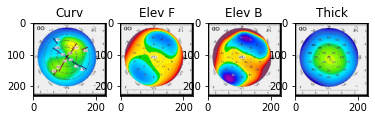

In [44]:
# Test the model
# model = ResNet50(img_channel=12, num_classes=3).to(device)
# model.load_state_dict(torch.load('resnet18_channelVise_Farabi.ckpt'))
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        _, labels_ = torch.max(labels, 1)

        total += labels.size(0)

        for i in range(len(predicted)):
          if (predicted[i] == labels_[i]):
            correct = correct +1
          else:
            print("Predict {} // Label {}".format(predicted[i],labels_[i]))
            img = images[i].to('cpu')
            img = img.numpy()
            img = img.transpose(1,2,0)

            plt.figure()
            f, axarr = plt.subplots(1,4)

            axarr[0].imshow(img[:,:,0:3])
            axarr[0].set_title("Curv")

            axarr[1].imshow(img[:,:,3:6])
            axarr[1].set_title("Elev F")
                                
            axarr[3].imshow(img[:,:,6:9])
            axarr[3].set_title("Thick")
                                
            axarr[2].imshow(img[:,:,9:12])
            axarr[2].set_title("Elev B")

In [45]:
print('{} wrong among {}'.format(total-correct,total))
print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

1 wrong amoung 75
Accuracy of the model on the test images: 98.66666666666667 %


In [ ]:
# # Test the model
# model_best_loss = ResNet50(img_channel=12, num_classes=3).to(device)
# model_best_loss.load_state_dict(torch.load('resnet18_channelVise_Farabi.ckpt'))
# model_best_loss.eval()

# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         _, labels_ = torch.max(labels, 1)
#         total += labels.size(0)
#         for i in range(int(train_input.shape[0]/batch_size)+1):
#           if predicted[i]==labels_[i]:
#             correct = correct+1
#           else:
#             print("predict is:",predicted[i],"label is",labels_[i])
#     print('{} wrong amoung {}'.format(total-correct,total))
#     print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [15]:
    # # Decay learning rate
    # if (last_loss / this_loss) >= 6:
    #     curr_lr /= 2.3
    #     last_loss = this_loss
    #     print("Change LR: Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Learning Rate: {}".format(epoch+1, num_epochs, i+1, total_step, loss.item(),curr_lr))
    #     update_lr(optimizer, curr_lr)

# # Save the model checkpoint
# if this_loss < sample_loss:
#   torch.save(model.state_dict(), 'resnet18_channelVise_Farabi.ckpt')
#   print("Save: Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))
#   sample_loss = this_loss

In [46]:
torch.save(model.state_dict(), 'resnet18_channelVise_Farabi.ckpt')

In [ ]:
from google.colab import files
files.download('/content/resnet18_channelVise_Farabi.ckpt') 